In [41]:
from dataloader import *
from model import *
from train import *
from utils import *

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torchvision.transforms as transforms

In [42]:
assert torch.cuda.is_available()

## Data Exploration

In [43]:
train_loader = get_train_valid_loaders(batch_size=1, phase='test')['train']

captions_file = "data/flickr8k/captions.txt"
df = pd.read_csv(captions_file)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [45]:
df

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 2 columns]

As can be seen above, each image has 5 captions, it means that during training all 5 captions should be taken into account when evaluating models performance.

In [46]:
num_images = len(df.image.unique())
train_img_size, valid_img_size = int(num_images*0.8), int(num_images*0.2)
train_cap_size, valid_cap_size = train_img_size*5, valid_img_size*5
print('There are {} images in the dataset'.format(num_images))
print('Training set will contain {} images and {} captions'.format(train_img_size, train_cap_size))
print('Validation set will contain {} images and {} captions'.format(valid_img_size, valid_cap_size))


There are 8091 images in the dataset
Training set will contain 6472 images and 32360 captions
Validation set will contain 1618 images and 8090 captions


### Understand the Data

In [47]:
loader_iter = iter(train_loader)
_, caps = next(loader_iter)
print(caps)

tensor([[[   1,    1,    1,    1,    1]],

        [[   4,    4,    4,  207,  207]],

        [[  14,  207,  207,    3,  516]],

        [[ 732,  516,  516,    3, 2453]],

        [[ 349,  622,   12,    3,   27]],

        [[  27,   99,   58, 2453,   10]],

        [[1166,    4,    4,   27,  617]],

        [[  10, 1088,   58, 2925,    5]],

        [[ 207,    5,  897,    4,    2]],

        [[  36,    2,   13,   36,    0]],

        [[   5,    0,   17,    5,    0]],

        [[   2,    0,  349,    2,    0]],

        [[   0,    0,   27,    0,    0]],

        [[   0,    0, 1166,    0,    0]],

        [[   0,    0,   10,    0,    0]],

        [[   0,    0,   36,    0,    0]],

        [[   0,    0,    5,    0,    0]],

        [[   0,    0,    2,    0,    0]]])


In [48]:
for _ in range(2):
    batch = next(loader_iter)
    imgs, caps = batch
    print('Images shape: {}'.format(imgs.shape))
    print('Captions shape: {}'.format(caps.shape))
    print()

Images shape: torch.Size([1, 3, 400, 400])
Captions shape: torch.Size([23, 1, 5])

Images shape: torch.Size([1, 3, 400, 400])
Captions shape: torch.Size([23, 1, 5])



The data will be provided to the model as follow:  
Images:     [B, C, H, W]  
Captions:   [MS, B, NC]

B=batch size  
MS=max sentence length  
NC=number of captions per image

As the images shape is quite understandable, the captions is a bit weird.  
This shape is due to the different sentences length between the different samples.  
When working with batches, the samples whitin each batch should be equals size, therefore, it is not possible to represent sentences with different lengths with a normal shape, and much easier to padding short sentences in that shape.  
The first sentence present along the first column of the matrix, the second sentence in the second column, and so on.

### Data Samples

In [49]:
def get_sentences(dataloader, captions):
    captions = captions.squeeze(1)
    captions = torch.permute(captions, (1, 0))
    num_sentences, num_word = captions.shape
    sentences = []
    for i in range(num_sentences):
        words = [ dataloader.dataset.vocab.itos[int(word)] for word in captions[i] ]    #   convert tokenizes to words
        eos_index = words.index('<EOS>')        #   find index of <EOS>
        words = words[1 : eos_index]            #   remove <SOS> and <EOS>
        sen = ' '.join(words)
        sentences.append(sen)

    return sentences

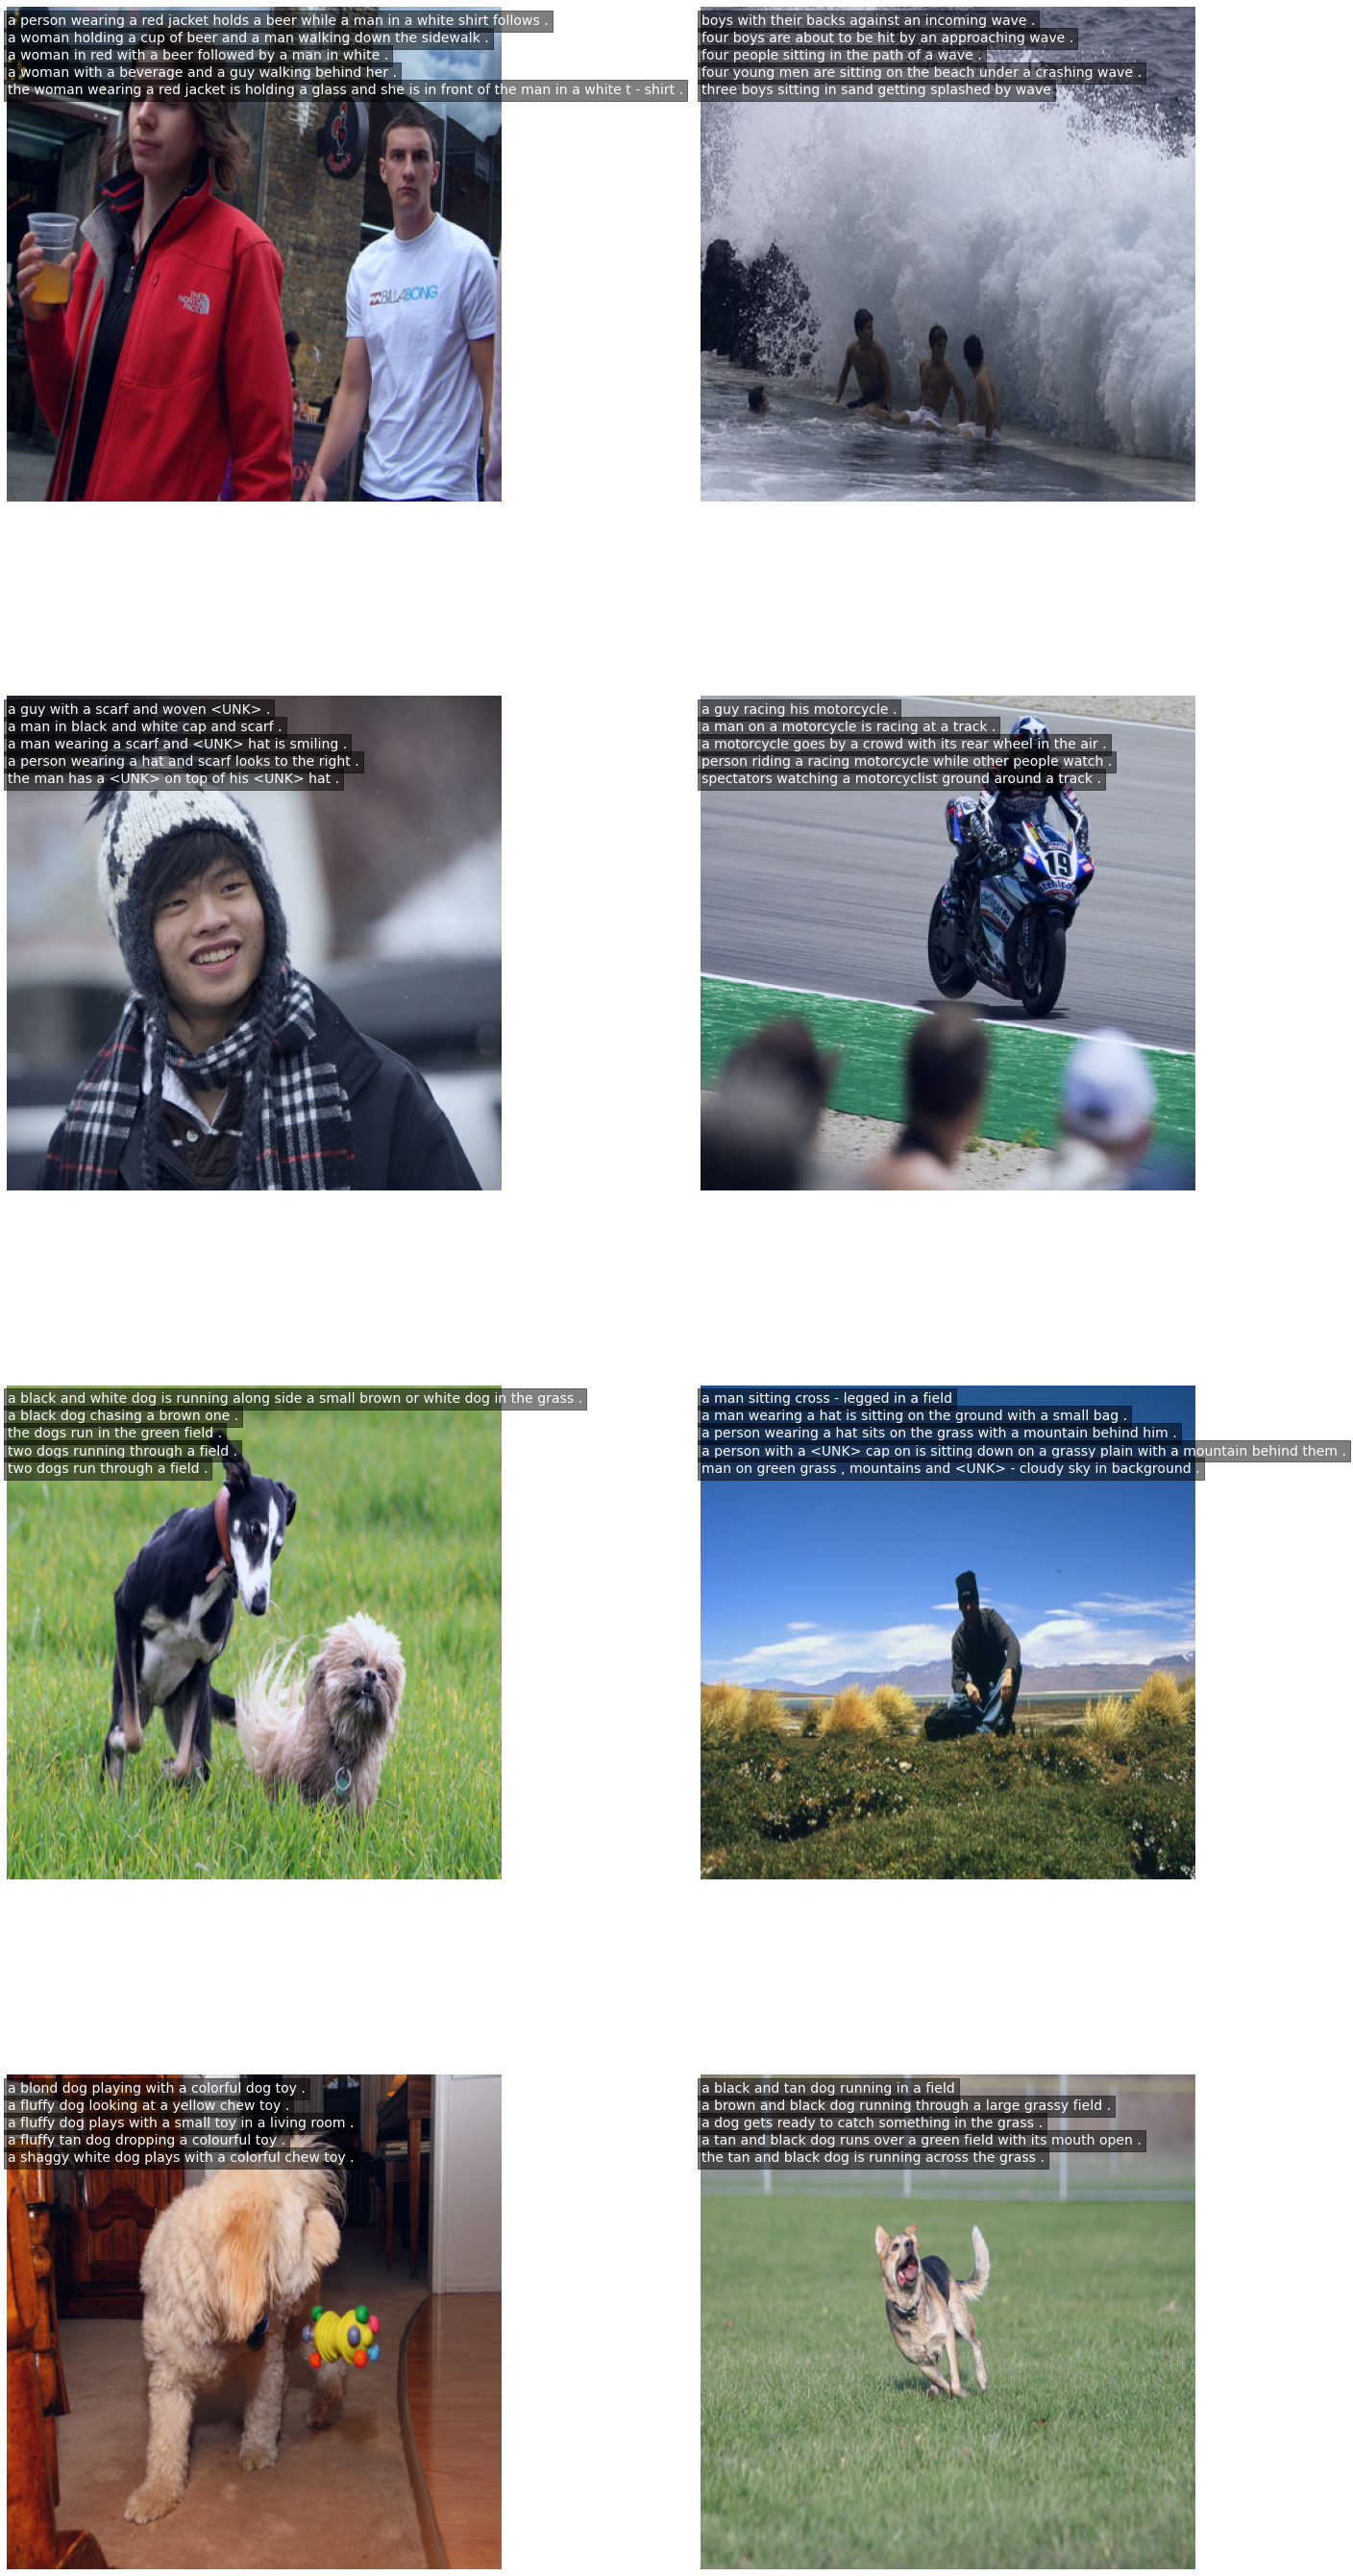

In [50]:
def show_example(dataloader, rows=4, cols=2):
    num_examples = cols*rows
    global_offset = 14

    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(10*cols, 10*rows))
    for idx, (img, captions) in enumerate(dataloader):
        if idx == num_examples:
            break

        img = img.squeeze(0)
        img = np.transpose(img, (1, 2, 0))
        sentences = get_sentences(dataloader, captions)

        ridx, cidx = idx//cols, idx%cols
        axs[ridx, cidx].imshow(norm(img))
        offset = global_offset
        for sen in sentences:
            axs[ridx, cidx].text(0, offset, sen, fontsize=global_offset, color='white', bbox=dict(facecolor='black', alpha=0.5))
            offset += global_offset
        axs[ridx, cidx].axis('off')
    plt.tight_layout()
    plt.show()

show_example(train_loader)